
# Identifying Possible Locations for a New Liquor Store in Iowa

## Executive Summary
Hawkeye Liquor Mart (*note: fake company name*) is considering opening a new liquor store in Iowa.  As a first step, this analysis is meant to help identify geographic areas that merit more intensive market research and scouting. This executive summary provides a high-level synopsis of the approach, findings, limitations, and recommended next steps.

## Approach
This analysis works primarily with a dataset obtained from the Iowa Alcoholic Beverages Division, which contains transaction records of liquor sales to retailers holding Class E Liquor licenses.

The primary analytical approach was to assess Iowa counties to identify where there is evidence that:
- Existing stores perform well
- The market is not saturated
- The population is relatively affluent

Through standard analysis techniques and incorporating basic population and economic data, this analysis derived a "Opportunity Score" metric which assigns a numerical score based on the three factors above.

## Findings
There are 15 counties (out of 99) that are in the top 75% percentile as measured by the Opportunity Score, and are recommended for further analysis.

Further, we can use basic linear regression to identify potential revenue levels that a new store might achieve in a given county (where we have sufficient data).  For example, among the top counties on the list, the baseline projected revenue is:
- Kossuth County: USD 204,000
- Polk County: USD 356,000
- Plymouth County: USD 129,000

## Limitations
It is important to note that the dataset does not include retail pricing (cost to consumer), only cost per unit to the liquor retailers.  Therefore, we should think of data labeled as "sales" or "revenue" as cost of goods sold (COGS).  While this does not allow us to calculate actual revenue or profit, it is a reasonable starting point to understand the market.

## Recommended Next Steps
This data and the resulting county list is intended to provide a starting point for deeper research into each county.  I recommend evaluating and understanding the list and prioritizing and/or pairing it down as needed.  In particular, I recommend researching actual retail pricing, and other margin-impacting measures (overhead, inventory turnover, etc.).


# Data Analysis and Code

## Data Cleaning and EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# Note: this file is large (>377 MB), which is why I have not made it available on Github.  If you are interested in 
# reproducing this, you can access the same data from the Iowa Alcoholic Beverages Division's website (https://abd.iowa.gov/)
# I may consider hosting this specific file if enough people express interest.
rawdata = pd.read_csv("../../datasets/Project2/Iowa_Liquor_Sales_reduced__FULL_SET.csv", header=0, low_memory=False)
rawdata.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,03/31/2016,5029,DAVENPORT,52806,82.000,Scott,1022100.000,TEQUILA,370,87152,Avion Silver,375,$9.99,$14.99,12,$179.88,4.500,1.190
1,03/31/2016,5029,DAVENPORT,52806,82.000,Scott,1022100.000,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,$12.50,$18.75,2,$37.50,2.000,0.530
2,03/31/2016,4959,CEDAR FALLS,50613,7.000,Black Hawk,1071100.000,AMERICAN COCKTAILS,380,63959,Uv Blue Raspberry Lemonade Pet,1750,$5.97,$8.96,6,$53.76,10.500,2.770
3,03/31/2016,2190,DES MOINES,50314,77.000,Polk,1031200.000,VODKA FLAVORED,205,40597,New Amsterdam Red Berry,200,$2.24,$3.36,48,$161.28,9.600,2.540
4,03/31/2016,5240,WEST BRANCH,52358,nan,NaN,1081200.000,CREAM LIQUEURS,305,73055,Rumchata,750,$12.50,$18.75,6,$112.50,4.500,1.190


In [3]:
# Replacing whitespace and special chars so that I don't have to use brackets & quotes every time I need to reference a column.

rawdata.columns = [c.replace(' ', '_') for c in rawdata.columns]
rawdata.columns = [c.replace('(', '') for c in rawdata.columns]
rawdata.columns = [c.replace(')', '') for c in rawdata.columns]
rawdata.columns

Index([u'Date', u'Store_Number', u'City', u'Zip_Code', u'County_Number',
       u'County', u'Category', u'Category_Name', u'Vendor_Number',
       u'Item_Number', u'Item_Description', u'Bottle_Volume_ml',
       u'State_Bottle_Cost', u'State_Bottle_Retail', u'Bottles_Sold',
       u'Sale_Dollars', u'Volume_Sold_Liters', u'Volume_Sold_Gallons'],
      dtype='object')

In [4]:
rawdata.shape

(2709552, 18)

In [5]:
rawdata.isnull().sum()

Date                       0
Store_Number               0
City                       0
Zip_Code                   0
County_Number          10913
County                 10913
Category                 779
Category_Name           6109
Vendor_Number              0
Item_Number                0
Item_Description           0
Bottle_Volume_ml           0
State_Bottle_Cost          0
State_Bottle_Retail        0
Bottles_Sold               0
Sale_Dollars               0
Volume_Sold_Liters         0
Volume_Sold_Gallons        0
dtype: int64

There are missing values in County_Number, County, Category, Category_Name.  I really only care about County and Category_Name.

In [6]:
rawdata.dtypes

Date                    object
Store_Number             int64
City                    object
Zip_Code                object
County_Number          float64
County                  object
Category               float64
Category_Name           object
Vendor_Number            int64
Item_Number              int64
Item_Description        object
Bottle_Volume_ml         int64
State_Bottle_Cost       object
State_Bottle_Retail     object
Bottles_Sold             int64
Sale_Dollars            object
Volume_Sold_Liters     float64
Volume_Sold_Gallons    float64
dtype: object

Some of these clearly need to be changed--Date should be a date/time format, and all cost oriented variables should be floats.

In [7]:
# Strip out the non-numeric characters in the cost-related variables
rawdata.State_Bottle_Cost.replace('[\$,)]','', regex=True, inplace=True)
rawdata.State_Bottle_Retail.replace('[\$,)]','', regex=True, inplace=True)
rawdata.Sale_Dollars.replace('[\$,)]','', regex=True, inplace=True)

# Now convert them to floats
rawdata.State_Bottle_Cost = rawdata.State_Bottle_Cost.astype(float, copy=True)   
rawdata.State_Bottle_Retail = rawdata.State_Bottle_Retail.astype(float, copy=True) 
rawdata.Sale_Dollars = rawdata.Sale_Dollars.astype(float, copy=True) 

In [8]:
# Converting Date to datetime
rawdata.Date = pd.to_datetime(rawdata.Date)

In [9]:
# Converting zip codes to floats for now (even though zip codes are categorical, this can 
# identify data issues)
rawdata.Zip_Code = rawdata.Zip_Code.astype(int, copy=True, raise_on_error=False)

In [10]:
# What county is this value associated with?
rawdata[rawdata.Zip_Code == '712-2'].County.value_counts()

Harrison    1725
Name: County, dtype: int64

In [11]:
# Assigning Harrison county to the county NaNs where zip code = 712-2
rawdata.loc[rawdata.Zip_Code == '712-2', 'County'] = 'Harrison'

What cities are associated with Harrison and 712-2?

In [12]:
rawdata[(rawdata.County == 'Harrison') & (rawdata.Zip_Code == '712-2')].City.value_counts()

DUNLAP    2000
Name: City, dtype: int64

All of them are Dunlap, IA. What zip code is Dunlap?

In [13]:
rawdata[rawdata.City == 'DUNLAP'].Zip_Code.value_counts()

712-2    2000
Name: Zip_Code, dtype: int64

All are 712-2, the error value.  Need a correct source to fix this.  I found a listing of all Iowa zip codes and corresponding counties and cities [here](http://www.zipcodestogo.com/Iowa/).  I copied the data into a csv file.

In [14]:
# Manually scraped from website and saved to CSV. Source: http://www.zipcodestogo.com/Iowa/
iowa_zips = pd.read_csv("../../datasets/Project2/Iowa_zips_list.csv", header=0)
# Renaming columns to avoid duplication with column names in the rawdata, for merging purposes.
iowa_zips.rename(columns={'Zip Code':'zip_code_ref', 'County':'county_ref'}, inplace=True)

In [15]:
iowa_zips.dtypes

zip_code_ref     int64
City            object
county_ref      object
dtype: object

In [16]:
# Looking up zip code for Dunlap.  I don't know text format, so passing all caps and title caps.
print "Dunlap zip code is: " + str(iowa_zips[(iowa_zips.City == 'DUNLAP') | (iowa_zips.City == "Dunlap")].zip_code_ref )

Dunlap zip code is: 651    51529
Name: zip_code_ref, dtype: int64


In [17]:
# Assigning correct zip code to Dunlap in the rawdata table
rawdata.loc[rawdata.City == 'DUNLAP', 'Zip_Code'] = '51529'
# Confirming change
rawdata[rawdata.City == 'DUNLAP'].Zip_Code.value_counts()

51529    2000
Name: Zip_Code, dtype: int64

In [18]:
# Converting all zips to integers
rawdata.Zip_Code = rawdata.Zip_Code.astype(int)

Now to fix the missing county values.  The iowa_zips df can also help with that.

In [19]:
# Merging rawdata and iowa_zips on their respective zip code columns.
dataset = pd.merge(rawdata, iowa_zips[['zip_code_ref', 'county_ref']], left_on='Zip_Code', right_on='zip_code_ref')


In [20]:
dataset.head()

,Date,Store_Number,City,Zip_Code,County_Number,County,Category,Category_Name,Vendor_Number,Item_Number,Item_Description,Bottle_Volume_ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Volume_Sold_Gallons,zip_code_ref,county_ref
0,2016-03-31,5029,DAVENPORT,52806,82.000,Scott,1022100.000,TEQUILA,370,87152,Avion Silver,375,9.990,14.990,12,179.880,4.500,1.190,52806,Scott
1,2016-03-31,5029,DAVENPORT,52806,82.000,Scott,1022100.000,TEQUILA,395,89197,Jose Cuervo Especial Reposado Tequila,1000,12.500,18.750,2,37.500,2.000,0.530,52806,Scott
2,2016-03-31,5029,DAVENPORT,52806,82.000,Scott,1022100.000,TEQUILA,410,88294,Patron Silver Tequila,375,14.000,21.000,12,252.000,4.500,1.190,52806,Scott
3,2016-03-31,5029,DAVENPORT,52806,82.000,Scott,1052010.000,IMPORTED GRAPE BRANDIES,389,49185,Remy Martin Vsop (flask),375,10.660,15.990,12,191.880,4.500,1.190,52806,Scott
4,2016-03-31,5029,DAVENPORT,52806,82.000,Scott,1022100.000,TEQUILA,410,88296,Patron Tequila Silver,750,27.000,40.500,12,486.000,9.000,2.380,52806,Scott


In [21]:
# county_ref replaces County.
dataset.drop('County', axis=1, inplace=True)
dataset.rename(columns={'county_ref': 'County'}, inplace=True)

I want to add a few more date-oriented columns to the master dataset, in case it proves useful.

In [22]:
dataset['Quarter'] = dataset.Date.dt.quarter
dataset['Year'] = dataset.Date.dt.year
dataset['Month'] = dataset.Date.dt.month
dataset['Year_Quarter'] = dataset.Year.astype(str) + '-Q' + dataset.Quarter.astype(str)

### Exploring Summary Stats & Distributions

In [23]:
dataset.describe()

,Store_Number,Zip_Code,County_Number,Category,Vendor_Number,Item_Number,Bottle_Volume_ml,State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Sale_Dollars,Volume_Sold_Liters,Volume_Sold_Gallons,zip_code_ref,Quarter,Year,Month
count,2695123.000,2695123.000,2684210.000,2694349.000,2695123.000,2695123.000,2695123.000,2695123.000,2695123.000,2695123.000,2695123.000,2695123.000,2695123.000,2695123.000,2695123.000,2695123.000,2695123.000
mean,3584.177,51258.332,57.253,1043845.577,256.410,46023.501,925.280,9.823,14.750,9.841,129.300,8.937,2.361,51258.332,2.255,2015.194,5.819
std,947.805,987.564,27.351,50110.180,140.919,53201.525,546.595,14.938,22.407,23.546,400.420,28.309,7.478,987.564,1.172,0.395,3.620
min,2106.000,50002.000,1.000,1011100.000,10.000,146.000,0.000,0.890,1.340,1.000,1.340,0.000,0.000,50002.000,1.000,2015.000,1.000
25%,2603.000,50315.000,31.000,1012200.000,115.000,26827.000,750.000,5.510,8.270,2.000,30.540,1.500,0.400,50315.000,1.000,2015.000,3.000
50%,3715.000,51054.000,62.000,1031200.000,260.000,38176.000,750.000,8.090,12.300,6.000,70.560,5.250,1.390,51054.000,2.000,2015.000,5.000
75%,4374.000,52310.000,77.000,1062310.000,380.000,64601.000,1000.000,11.960,17.940,12.000,135.000,10.500,2.770,52310.000,3.000,2015.000,9.000
max,9023.000,52807.000,99.000,1701100.000,978.000,999275.000,225000.000,6468.000,9702.000,3960.000,106326.000,3960.000,1046.120,52807.000,4.000,2016.000,12.000


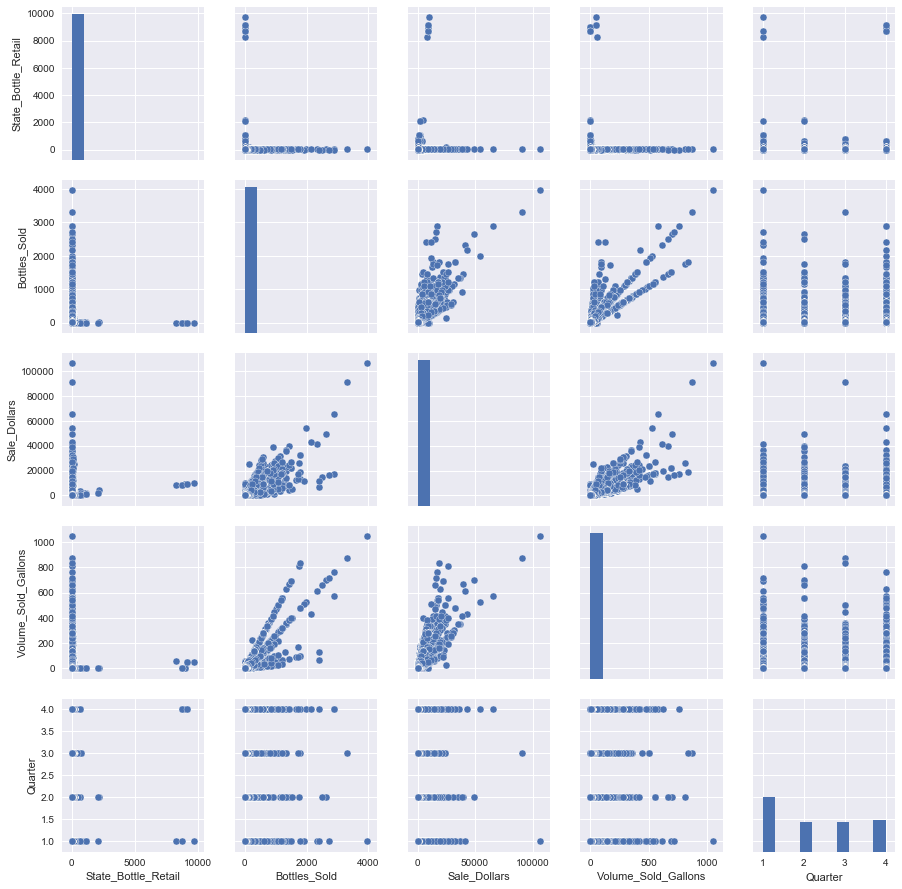

In [25]:
sns.pairplot(dataset, vars=['State_Bottle_Retail', 'Bottles_Sold', 'Sale_Dollars', 'Volume_Sold_Gallons', 'Quarter'])

A lot of pretty obvious linear relationships here, like gallons of alcohol sold vs sales (or bottles).  Interestingly, the plots by quarter suggest there might be some seasonality in Q2 and Q4.

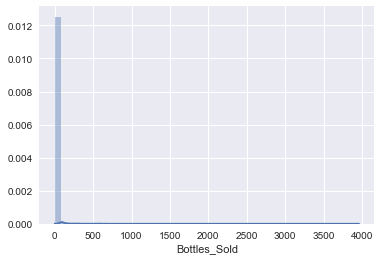

In [26]:
sns.distplot(dataset.Bottles_Sold)
# VERY skewed

## Data Transformation
Because the master dataset is at the transaction level, I need to make some summary tables in order to be able to start to analyze which counties might be the right places to consider.

### Store-Level Stats

In [24]:
# Creating a rollup view of store performance on key measures.
store_summary = dataset.pivot_table(index='Store_Number', values=['Bottles_Sold', 'Sale_Dollars','Volume_Sold_Gallons'], aggfunc=np.sum)

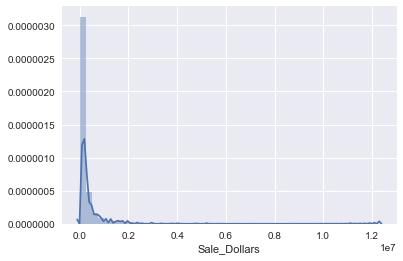

In [25]:
sns.distplot(store_summary.Sale_Dollars)

The distribution of Sale_Dollars (e.g., what the liquor stores paid to the state) is extremely right skewed.  That said, the bulk of the data does not have any abnormal or jagged shape that might be difficult to interpret.

In [26]:
# Converting the pivot table to a dataframe
store_summary_df = pd.DataFrame(store_summary)
# Setting the store ID as the index
store_summary['Store_ID'] = store_summary.index

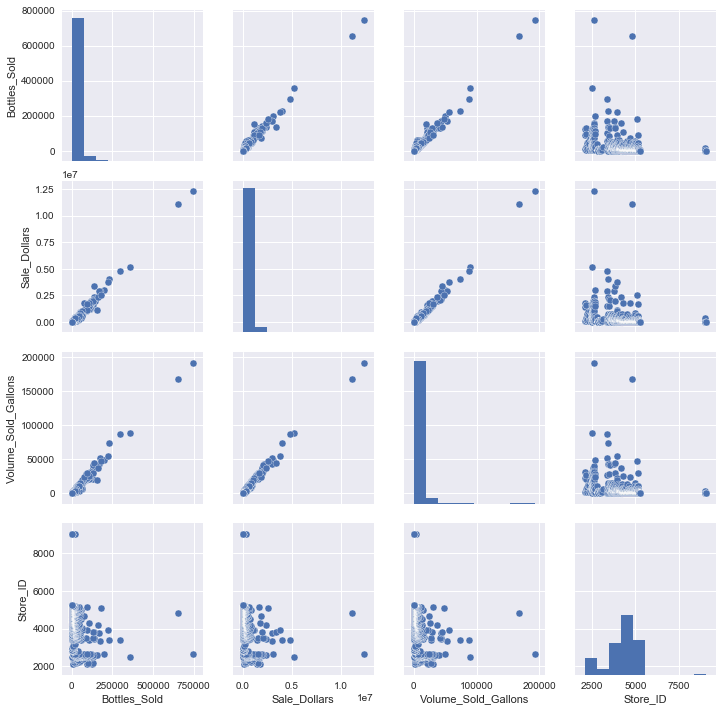

In [30]:
sns.pairplot(store_summary)

This is not at all surprising.  The pairs that are relevant (store ID should be ignored since it is an arbitrary number), are extremely well correlated.

While it's obvious that volume of alcohol sold would be linearly related to dollar amount, it's still important to verify.  In particular, this leads me to believe that there is not a noticable segment of specialty or high-end liquor stores that might sell fewer gallons but at a higher price per gallon.

In [27]:
# Stores list--deduping master dataset by store_number to grab county, city, zip code by store.
stores = dataset.copy()
stores.drop_duplicates("Store_Number", inplace=True)

In [28]:
# I only want unique stores for this.
stores.drop(['Item_Number', 'Item_Description', 'Bottle_Volume_ml', 'State_Bottle_Cost', 'State_Bottle_Retail', 'Bottles_Sold', 'Sale_Dollars', 'Volume_Sold_Liters', 'Volume_Sold_Gallons', 'Category_Name', 'Quarter', 'Year', 'Month', 'Year_Quarter', 'Date', 'Category'], axis=1, inplace=True)

In [29]:
# Merging the store-oriented dataframes into one, store performance dataframe
stores_performance = pd.merge(stores, store_summary_df, left_on='Store_Number', right_on='Store_ID')

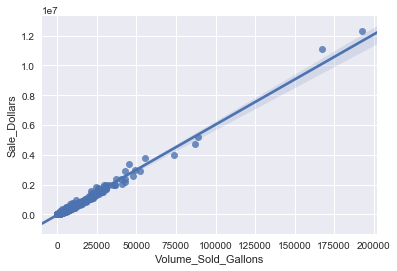

In [34]:
sns.regplot(x='Volume_Sold_Gallons', y='Sale_Dollars', data=stores_performance)

This tells me that there's no differentiation in revenue based on selling expensive vs. cheap/regular price alcohol. If that were the case, there would at least be some notable outliers where revenue (Sales_Dollars) was higher as compared to the liquid volume of alcohol sold.

In [30]:
# Adding calculated columns related to store performance
stores_performance['Avg_Bottles_Sold'] = stores_performance.Sale_Dollars / stores_performance.Bottles_Sold
stores_performance['Avg_Bottle_Size_Gal'] = stores_performance.Volume_Sold_Gallons / stores_performance.Bottles_Sold

### County-Level Stats

In [31]:
# Summing up performance by county
county_sums = dataset.pivot_table(index='County', values=['Bottles_Sold', 'Sale_Dollars','Volume_Sold_Gallons'], aggfunc=np.sum)
county_sums.rename(columns={'Bottles_Sold': 'Total_Bottles_Sold', 'Sale_Dollars': 'Total_Sales', 'Volume_Sold_Gallons': 'Total_Gallons_Sold'},inplace=True)

In [32]:
# Counting unique number of stores per county
stores_per_county = dataset.pivot_table(index='County', values='Store_Number', aggfunc=lambda x: len(x.unique()))
stores_per_county = pd.DataFrame(stores_per_county)
stores_per_county.rename(columns={'Store_Number': 'Count_of_Stores'}, inplace=True)

In [33]:
# Calculating median values at the county level
county_medians = stores_performance.pivot_table(index='County', values=['Sale_Dollars', 'Bottles_Sold', 'Volume_Sold_Gallons'], aggfunc=np.median)
county_medians.rename(columns={'Sale_Dollars' : 'Median_Sales', 'Bottles_Sold': 'Median_Bottles_Sold', 'Volume_Sold_Gallons': 'Median_Gallons_Sold'},inplace=True)

In [34]:
# Calculating mean values at the county level
county_means = stores_performance.pivot_table(index='County', values=['Sale_Dollars', 'Bottles_Sold', 'Volume_Sold_Gallons'], aggfunc=np.mean)
county_means.rename(columns={'Sale_Dollars' : 'Mean_Sales', 'Bottles_Sold': 'Mean_Bottles_Sold', 'Volume_Sold_Gallons': 'Mean_Gallons_Sold'},inplace=True)

In [35]:
# Merging the pivot tables into a master dataframe of county-level stats
county_master = pd.merge(stores_per_county, county_sums, left_index=True, right_index=True)
county_master = pd.merge(county_master, county_means, left_index=True, right_index=True)
county_master = pd.merge(county_master, county_medians, left_index=True, right_index=True)

In [36]:
# Adding calculated columns at the county level
county_master['Avg_Sales_per_Store'] = county_master.Total_Sales / county_master.Count_of_Stores
county_master["Avg_Price_per_Bottle"] = county_master.Total_Sales / county_master.Total_Bottles_Sold

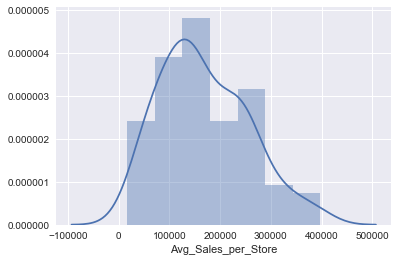

In [37]:
sns.distplot(county_master.Avg_Sales_per_Store)

This plot is very interesting--it shows the distribution of average sales per store (distribution of means), and it looks very close to a normal distribution.  This is probably the central limit theorem at work.

Now, it's helpful to explore the variables to identify any correlations that might be of interest for modeling purposes.

In [38]:
feature_correlation_matrix = np.corrcoef(county_master.T)
feature_correlation_matrix

array([[ 1.        ,  0.98999848,  0.98635155,  0.98996605,  0.54600617,
         0.53240087,  0.44839641,  0.08582828, -0.01728394, -0.08454499,
         0.53240087,  0.09594789],
       [ 0.98999848,  1.        ,  0.99855936,  0.9989693 ,  0.56241395,
         0.55026813,  0.46909394,  0.12850948,  0.03074696, -0.03409194,
         0.55026813,  0.09697773],
       [ 0.98635155,  0.99855936,  1.        ,  0.99927445,  0.55324953,
         0.54572563,  0.46505384,  0.11969717,  0.02837408, -0.03494363,
         0.54572563,  0.11261634],
       [ 0.98996605,  0.9989693 ,  0.99927445,  1.        ,  0.56627649,
         0.55759603,  0.47840223,  0.12552183,  0.03268836, -0.03191289,
         0.55759603,  0.11499437],
       [ 0.54600617,  0.56241395,  0.55324953,  0.56627649,  1.        ,
         0.99163517,  0.97652045,  0.63384614,  0.54019713,  0.47256971,
         0.99163517,  0.36764752],
       [ 0.53240087,  0.55026813,  0.54572563,  0.55759603,  0.99163517,
         1.        ,  

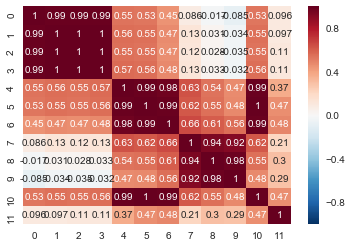

In [39]:
import seaborn.linearmodels as sblm
sns.heatmap(feature_correlation_matrix, annot=True, xticklabels=True, yticklabels=True)

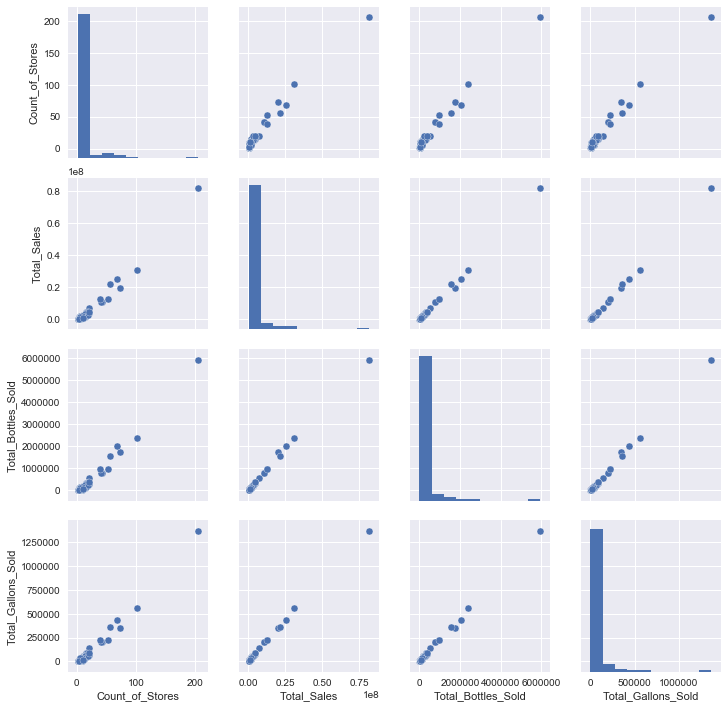

In [40]:
sns.pairplot(county_master[['Count_of_Stores', 'Total_Sales', 'Total_Bottles_Sold', 'Total_Gallons_Sold']])

Again, the correlation coefficients and the plots are showing exactly the relationships you'd expect (e.g., volume to dollars, etc.).

To hopefully make this analysis more meaningful, I want to incorporate county-level population and per-capita income.  Regardless of whether those stats will add or subtract from the existing linear relationships, they are certainly relevant from a business perspective in terms of deciding where to site a store.

In [41]:
# Loading population data. Source: Iowa.gov
county_pop = pd.read_csv("../../datasets/Project2/Total_County_Population_by_Year.csv", header=0, na_filter=False)

In [42]:
# Cleaning the county name column
county_pop['County_clean'] = county_pop.County.map(lambda x: x.rstrip(' County'))
# Merging into the county dataset
county_master = pd.merge(county_master, county_pop[['Population', 'County_clean']], left_index=True, right_on='County_clean')

In [43]:
# Creating a measure of liquor stores per capita in each county
county_master['Stores_per_Capita'] = county_master.Count_of_Stores / county_master.Population

In [44]:
# Loading mean per-capita income by county.  Source: http://www.icip.iastate.edu/tables/income/per-capita-income
income = pd.read_table("../../datasets/Project2/Iowa_income_per_county.txt", header=0, na_filter=False)
# The first two entries are all US and all Iowa, so we need to drop these.
income.drop([0,1], axis=0, inplace=True)
income.rename(columns={"Area Name": "Area_Name"}, inplace=True)


In [45]:
#Merging the data into the county dataset
county_master = pd.merge(county_master, income[['Area_Name', '2013']], left_on='County_clean', right_on='Area_Name')

county_master.rename(columns={'2013': 'Mean_Income_per_Capita_2013'}, inplace=True)

# Income values are strings; striping the non-numerical characters and converting to floats.
county_master.Mean_Income_per_Capita_2013 =  county_master.Mean_Income_per_Capita_2013.str.replace(',', '')
county_master.Mean_Income_per_Capita_2013 = county_master.Mean_Income_per_Capita_2013.astype(float, inplace=True)

## Pre-Processing

There are a number of potentially important numerical columns in the dataset, but they are based on different measurements and categories (e.g., gallons and dollars).  They should be normalized so that they can be compared directly without one variable falsely skewing the results.

In [46]:
# Formula to normalize the data around its standard deviation.
def normalizer(column):
    normalized_list = []
    for i in column:
        standardized_numbers = (i - np.mean(column))/np.std(column)
        normalized_list.append(standardized_numbers)
        normalized_series = np.array(normalized_list)
    return normalized_series

In [47]:
# Calling the normalizer function on key variables
Mean_Sales_Norm = normalizer(county_master.loc[:,'Mean_Sales'])
Avg_Sales_Store_Norm = normalizer(county_master.loc[:, 'Avg_Sales_per_Store'])
Count_of_Stores_Norm = normalizer(county_master.loc[:, 'Count_of_Stores'])
income_norm = normalizer(county_master.loc[:, 'Mean_Income_per_Capita_2013'])
Stores_per_Capita_Norm = normalizer(county_master.loc[:, 'Stores_per_Capita'])

In [48]:
# Appending the normalized columns to the dataframe
county_master['Count_of_Stores_Norm'] = Count_of_Stores_Norm
county_master['Mean_Sales_Norm'] = Mean_Sales_Norm
county_master['Avg_Sales_Store_Norm'] = Avg_Sales_Store_Norm
county_master['Income_Norm'] = income_norm
county_master['Stores_per_Capita_Norm'] = Stores_per_Capita_Norm

## Analysis and Modeling

### Working with Indirect Measures
Perhaps the primary challenge with this analysis is that the dataset is oriented from the perspective of the Iowa Alcoholic Beverage Division.  In other words, it shows explicit data on the state's purchasing liquor and reselling it to licensees (liquor stores).  However, from a commercial perspective, this is only wholesale data.  It does not provide any information on retail prices (i.e., cost to consumers), and therefore we are unable to directly measure:
- Store revenue
- Product-level margin
- Store profits (which would also require other cost information not included)

This means that the data labeled with words like "Sales" is actually, from our perspective, cost.  Specifically, we can think of it as cost of goods sold, or COGS.  This metric is still useful, and we can use it as a loose proxy for estimating revenue.  However, we must keep in mind that the amount is really cost--we don't know how much markup the stores apply, nor do we know how much excess inventory they hold at any given time.  

With those caveats in mind, we can still glean usefull insights from the data to help inform next steps.

### The Opportunity Metric
The objective of this analysis is to identify counties based on whether they present a good opportunity for opening a new liquor store--in other words, a location where we think we can maximize revenue.  One way to look at it (and a way that is possible with the data we have) is to say, we want to find a location where a) the market is not already saturated; b) existing stores tend to do well; and c) the local population is relatively affluent.

THe opportunity metric or opportunity score is a derived number that takes those three things into account, with a basic formula:
For each county:
- Begin with the normalized average "sales" (COGS) per store.  (Again, we are using COGS as a leading indicator of revenue.)
- Subtract the stores per capita--through standardization, some of these values are positive and some are negative.  A negative value means a lower score per capita, so subtracting a negative value gives a positive impact on the score (double negative).  Likewise, if a market is more saturated, its stores per capita measure will be a positive value, and we subtract it from the score as a penalty.
- Add the normalized mean per-capita income, to boost the score of wealthier counties (who presumably have more disposable income to spend on Hawkeye Soy Schnapps).

In [49]:
# Calculating the opportunity metric and appending it to the county_master dataframe
county_master['Opportunity_Metric'] = county_master.Avg_Sales_Store_Norm - county_master.Stores_per_Capita_Norm + county_master.Income_Norm

In [50]:
county_master.sort_values(by='Opportunity_Metric', ascending=False).head(10)

,Count_of_Stores,Total_Bottles_Sold,Total_Sales,Total_Gallons_Sold,Mean_Bottles_Sold,Mean_Sales,Mean_Gallons_Sold,Median_Bottles_Sold,Median_Sales,Median_Gallons_Sold,...,County_clean,Stores_per_Capita,Area_Name,Mean_Income_per_Capita_2013,Count_of_Stores_Norm,Mean_Sales_Norm,Avg_Sales_Store_Norm,Income_Norm,Stores_per_Capita_Norm,Opportunity_Metric
33,6,142614,2004395.970,40376.220,23769.000,334065.995,6729.370,21211.000,303894.735,5935.105,...,Kossuth,0.000,Kossuth,57672.000,-0.263,2.187,2.187,1.678,-0.452,4.317
48,206,5949672,81917506.010,1369931.540,28881.903,397657.796,6650.153,9044.000,91333.145,1589.680,...,Polk,0.000,Polk,48118.000,6.950,2.994,2.994,0.409,-0.147,3.550
46,8,134579,1894119.760,37072.240,16822.375,236764.970,4634.030,11349.500,154580.905,3445.550,...,Plymouth,0.000,Plymouth,54841.000,-0.191,0.954,0.954,1.302,-0.949,3.205
58,5,114224,1578801.730,31907.430,22844.800,315760.346,6381.486,26615.000,352963.080,7333.940,...,Winneshiek,0.000,Winneshiek,42486.000,-0.299,1.955,1.955,-0.339,-1.501,3.118
1,1,10173,122431.290,2425.930,10173.000,122431.290,2425.930,10173.000,122431.290,2425.930,...,Adams,0.000,Adams,62055.000,-0.443,-0.496,-0.496,2.260,-1.352,3.116
16,18,250158,3374618.270,61033.620,13897.667,187478.793,3390.757,5074.500,56284.265,1097.525,...,Dallas,0.000,Dallas,48813.000,0.170,0.329,0.329,0.501,-1.616,2.446
53,9,123365,1834620.950,36425.130,13707.222,203846.772,4047.237,11863.000,152651.970,3279.950,...,Sioux,0.000,Sioux,48603.000,-0.154,0.537,0.537,0.473,-1.391,2.401
15,6,108825,1546616.330,30635.940,18137.500,257769.388,5105.990,7492.500,110241.695,2372.190,...,Crawford,0.000,Crawford,47899.000,-0.263,1.220,1.220,0.380,-0.756,2.356
44,2,23603,315369.900,6564.280,11801.500,157684.950,3282.140,11801.500,157684.950,3282.140,...,Osceola,0.000,Osceola,54204.000,-0.407,-0.049,-0.049,1.217,-0.933,2.101
40,4,40129,512250.220,11441.990,10032.250,128062.555,2860.498,10920.500,155817.785,3193.200,...,Mitchell,0.000,Mitchell,56861.000,-0.335,-0.424,-0.424,1.570,-0.632,1.777


In [51]:
county_master.Opportunity_Metric.describe()

count   60.000
mean    -0.000
std      1.860
min     -4.460
25%     -1.190
50%      0.034
75%      1.029
max      4.317
Name: Opportunity_Metric, dtype: float64

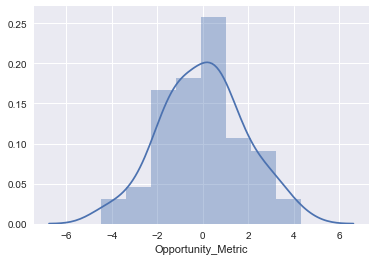

In [52]:
sns.distplot(county_master.Opportunity_Metric)

Based on the opportunity metric values, it seems prudent to make a value of >=10 the cutoff for considering counties (that may even be too many to investigate).

In [53]:
# Creating a subset dataframe of just the target counties
target_counties  = pd.DataFrame(county_master[county_master.Opportunity_Metric >= 1.0])
target_counties.rename(columns={'County_clean':'County'},inplace=True)
target_counties.set_index('County', inplace=True)

In [54]:
# Generating a summary report of counties to investigate, for the client.

# Subset the most relevant columns for the audience
report_df = pd.DataFrame(target_counties[['Count_of_Stores', 'Mean_Income_per_Capita_2013', 'Avg_Sales_per_Store', 'Population', 'Stores_per_Capita', 'Opportunity_Metric']])
# Rename the columns to be more readable
report_df.rename(columns={'Count_of_Stores': 'Existing Stores', 'Mean_Income_per_Capita_2013': 'Income per Capita', 'Avg_Sales_per_Store': 'Mean COGS per Store', 'Stores_per_Capita': 'Stores per Capita', 'Opportunity_Metric': 'Opportunity Score'}, inplace=True)

In [55]:
# Format the numbers to be more readable in the report itself
report_df['Income per Capita'] = report_df['Income per Capita'].map(lambda x: '${:,.2f}'.format(x))
report_df['Mean COGS per Store'] = report_df['Mean COGS per Store'].map(lambda x: '${:,.2f}'.format(x))
report_df['Stores per Capita'] = report_df['Stores per Capita'].round(6)
report_df['Opportunity Score'] = report_df['Opportunity Score'].round(2)

In [56]:
report_df.sort_values(by='Opportunity Score', ascending=False, inplace=True)

In [57]:
from bokeh.models import ColumnDataSource
from bokeh.models.layouts import WidgetBox 
from bokeh.models.widgets import DataTable, DateFormatter, TableColumn

In [58]:
from bokeh.charts import reset_output
reset_output() #Resets the output settings

In [59]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

In [61]:
# Creating summary table of top counties to consider for siting, given their Opportunity Score
# Using the Bokeh library to generate an interactive table that can be sorted and explored by the user.


source = ColumnDataSource(report_df)

columns = [
        TableColumn(field='County', title='County'),
        TableColumn(field='Opportunity Score', title='Opportunity Score'),
        TableColumn(field='Mean COGS per Store', title='Mean COGS per Store'),
        TableColumn(field='Stores per Capita', title='Stores per Capita'),
        TableColumn(field='Income per Capita', title='Income per Capita'),        
    ]
data_table = DataTable(source=source, columns=columns, width=800, height=500)

show(WidgetBox(data_table))